## Imports

In [1]:
import jax
import optax
import flax.linen as nn
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from flax.training import train_state

## Transformer Block

In [2]:
class TransformerBlock(nn.Module):
  d_model: int
  heads: int
  diff: int
  dropout_rate: float = 0.1

  @nn.compact
  def __call__(self, x, training = False):
    attn_out = nn.MultiHeadDotProductAttention(
        num_heads = self.heads,
        dtype=jnp.float32
    )(x, x)
    attn_out = nn.LayerNorm()(x + attn_out)

    ff_out = nn.Sequential([
        nn.Dense(self.diff, dtype=jnp.float32),
        nn.relu,
        # nn.Dropout(self.dropout_rate),
        nn.Dense(self.d_model, dtype = jnp.float32)
    ])(attn_out)
    return nn.LayerNorm()(attn_out + ff_out)


## Random Number Transformer with Iterative Reasoning Head

In [7]:
class RandomNumberTransformer(nn.Module):
  d_model: int
  heads: int
  diff: int
  num_layers: int
  vocab_size: int
  max_len: int

  def setup(self):
    self.shared_dense = nn.Dense(features = self.d_model)

  @nn.compact
  def __call__(self, x, training = False):
    x = nn.Embed(self.vocab_size, self.d_model)(x)
    pos = jnp.arange(0, x.shape[1], dtype = jnp.float32)[:, jnp.newaxis]
    div_term = jnp.exp(jnp.arange(0, self.d_model, 2) * -(jnp.log(10000) / self.d_model))
    pe = jnp.zeros((x.shape[1], self.d_model))
    pe = pe.at[:, 0::2].set(jnp.sin(pos * div_term))
    pe = pe.at[:, 1::2].set(jnp.cos(pos * div_term))
    x += pe[jnp.newaxis, :, :]

    for _ in range(self.num_layers):
      x = TransformerBlock(
          d_model = self.d_model,
          heads = self.heads,
          diff = self.diff,
          dropout_rate = 0.1
      )(x, training = training)
      x = self.shared_dense(x)
    return nn.Dense(self.vocab_size)(x)


## Training Utilities

In [8]:
def create_train_state(rng, model, input_shape):
  @jax.jit
  def initialize_model(rng):
    return model.init(rng, jnp.ones(input_shape, dtype=jnp.int32))["params"]

  params = initialize_model(rng)
  tx = optax.adam(learning_rate = 1e-3)

  return train_state.TrainState.create(
      apply_fn = model.apply,
      params = params,
      tx = tx
  )

## Loss and Update Step

In [9]:
def cross_entropy_loss(logits, labels):
  one_hot_labels = jax.nn.one_hot(labels, logits.shape[-1])
  return jnp.mean(-jnp.sum(one_hot_labels * jax.nn.log_softmax(logits), axis=-1))

@jax.jit
def train_step(state, batch):
  def loss_fn(params):
    logits = state.apply_fn({"params": params}, batch, training = True)
    loss = cross_entropy_loss(logits[:, :-1, :], batch[:, 1:])
    return loss

  grad_fn = jax.value_and_grad(loss_fn)
  loss, grads = grad_fn(state.params)
  return state.apply_gradients(grads = grads), loss

def generate_random_number_sequence(num_sequences, max_len, vocab_size):
  return np.random.randint(0, vocab_size, size = (num_sequences, max_len))


## Train and Generate

Epoch: 0 | Loss: 5.069095134735107
Epoch: 10 | Loss: 4.626975059509277
Epoch: 20 | Loss: 4.610742568969727
Epoch: 30 | Loss: 4.609151840209961
Epoch: 40 | Loss: 4.613515853881836
Epoch: 50 | Loss: 4.608266830444336
Epoch: 60 | Loss: 4.609899520874023
Epoch: 70 | Loss: 4.611582279205322
Epoch: 80 | Loss: 4.607863903045654
Epoch: 90 | Loss: 4.608782768249512
Epoch: 100 | Loss: 4.609195709228516
Epoch: 110 | Loss: 4.608584880828857
Epoch: 120 | Loss: 4.610080242156982
Epoch: 130 | Loss: 4.6110429763793945
Epoch: 140 | Loss: 4.609467506408691
Epoch: 150 | Loss: 4.607114315032959
Epoch: 160 | Loss: 4.607370376586914
Epoch: 170 | Loss: 4.608839988708496
Epoch: 180 | Loss: 4.607999801635742
Epoch: 190 | Loss: 4.60819149017334
Epoch: 200 | Loss: 4.607051849365234
Epoch: 210 | Loss: 4.605620861053467
Epoch: 220 | Loss: 4.608626842498779
Epoch: 230 | Loss: 4.610793590545654
Epoch: 240 | Loss: 4.606276512145996
Epoch: 250 | Loss: 4.606984615325928
Epoch: 260 | Loss: 4.601451396942139
Epoch: 270 |

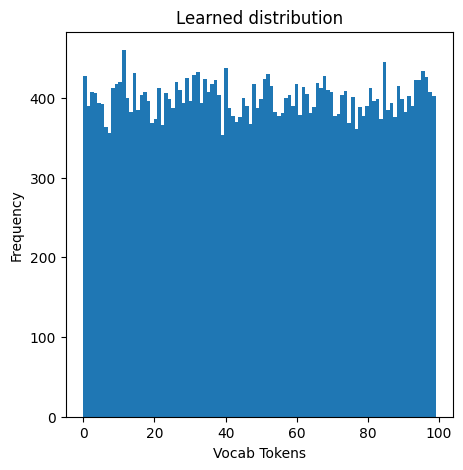

In [20]:
def main():
  vocab_size = 100
  max_len = 40
  d_model = 128
  diff = 64
  heads = 4
  layers = 2
  batch_size = 128
  epochs = 500
  evals = 1000

  model = RandomNumberTransformer(
      d_model = d_model,
      heads = heads,
      diff = diff,
      num_layers = layers,
      vocab_size = vocab_size,
      max_len = max_len
  )
  rng = jax.random.PRNGKey(42)
  rng, init_rng = jax.random.split(rng)
  state = create_train_state(
      init_rng,
      model,
      input_shape = (batch_size, max_len)
  )

  losses = []
  for i in range(epochs):
    batch = generate_random_number_sequence(batch_size, max_len, vocab_size)
    state, loss = train_step(state, batch)
    losses.append(loss)

    if i % 10 == 0:
      print(f"Epoch: {i} | Loss: {loss}")

  test_input = generate_random_number_sequence(1, max_len, vocab_size)
  generated_logits = model.apply({"params": state.params}, test_input, training = False)
  generated_logits = jax.nn.log_softmax(generated_logits, axis = -1)
  generated_sequence = jnp.argmax(generated_logits, axis = -1).reshape(max_len,)
  print(f"Generated Sequence: {generated_sequence}")

  test_input = generate_random_number_sequence(evals, max_len, vocab_size)
  generated_logits = model.apply({"params": state.params}, test_input, training = False)
  generated_logits = jax.nn.log_softmax(generated_logits, axis = -1)
  samples = jnp.argmax(generated_logits, axis = -1).reshape(evals * max_len,)
  plt.figure(figsize = (5, 5))
  plt.hist(samples, vocab_size)
  plt.title("Learned distribution")
  plt.xlabel("Vocab Tokens")
  plt.ylabel("Frequency")
  plt.show()


if __name__ == "__main__":
  main()

## Variation of Loss Vs Tokens

Epoch: 0 | Loss: 5.073994159698486
Epoch: 10 | Loss: 4.628123760223389
Epoch: 20 | Loss: 4.613058090209961
Epoch: 30 | Loss: 4.611587047576904
Epoch: 40 | Loss: 4.606966972351074
Epoch: 50 | Loss: 4.609611511230469
Epoch: 60 | Loss: 4.612318992614746
Epoch: 70 | Loss: 4.608325004577637
Epoch: 80 | Loss: 4.6099162101745605
Epoch: 90 | Loss: 4.608607292175293
Epoch: 100 | Loss: 4.608701229095459
Epoch: 110 | Loss: 4.610837459564209
Epoch: 120 | Loss: 4.608234882354736
Epoch: 130 | Loss: 4.609038352966309
Epoch: 140 | Loss: 4.609830856323242
Epoch: 150 | Loss: 4.607771873474121
Epoch: 160 | Loss: 4.610005855560303
Epoch: 170 | Loss: 4.606623649597168
Epoch: 180 | Loss: 4.608349800109863
Epoch: 190 | Loss: 4.608590126037598
Epoch: 200 | Loss: 4.607553958892822
Epoch: 210 | Loss: 4.608548641204834
Epoch: 220 | Loss: 4.607926368713379
Epoch: 230 | Loss: 4.606683254241943
Epoch: 240 | Loss: 4.605116844177246
Epoch: 250 | Loss: 4.604013442993164
Epoch: 260 | Loss: 4.594335079193115
Epoch: 270 

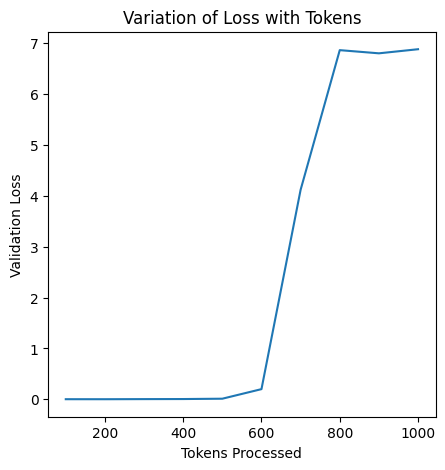

In [22]:
def main():
  vocab_sizes = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
  max_len = 40
  d_model = 128
  diff = 64
  heads = 4
  layers = 2
  batch_size = 128
  epochs = 500
  evals = 1000

  losses_all = []

  for vocab_size in vocab_sizes:
    model = RandomNumberTransformer(
        d_model = d_model,
        heads = heads,
        diff = diff,
        num_layers = layers,
        vocab_size = vocab_size,
        max_len = max_len
    )
    rng = jax.random.PRNGKey(42)
    rng, init_rng = jax.random.split(rng)
    state = create_train_state(
        init_rng,
        model,
        input_shape = (batch_size, max_len)
    )

    losses = []
    for i in range(epochs):
      batch = generate_random_number_sequence(batch_size, max_len, vocab_size)
      state, loss = train_step(state, batch)
      losses.append(loss)

      if i % 10 == 0:
        print(f"Epoch: {i} | Loss: {loss}")

    test_input = generate_random_number_sequence(1, max_len, vocab_size)
    generated_logits = model.apply({"params": state.params}, test_input, training = False)
    generated_logits = jax.nn.log_softmax(generated_logits, axis = -1)
    generated_sequence = jnp.argmax(generated_logits, axis = -1).reshape(max_len,)
    print(f"Generated Sequence: {generated_sequence}")
    losses_all.append(losses[-1])

  plt.figure(figsize = (5, 5))
  plt.plot(vocab_sizes, losses_all)
  plt.title("Variation of Loss with Tokens")
  plt.xlabel("Tokens Processed")
  plt.ylabel("Validation Loss")
  plt.show()


if __name__ == "__main__":
  main()

## Variation of Loss with Model Size

Epoch: 0 | Loss: 6.705958366394043
Epoch: 10 | Loss: 6.362419605255127
Epoch: 20 | Loss: 6.275084972381592
Epoch: 30 | Loss: 6.238122940063477
Epoch: 40 | Loss: 6.226171493530273
Epoch: 50 | Loss: 6.2211737632751465
Epoch: 60 | Loss: 6.217932224273682
Epoch: 70 | Loss: 6.21764612197876
Epoch: 80 | Loss: 6.2152299880981445
Epoch: 90 | Loss: 6.2168755531311035
Epoch: 100 | Loss: 6.2157063484191895
Epoch: 110 | Loss: 6.216546535491943
Epoch: 120 | Loss: 6.215851783752441
Epoch: 130 | Loss: 6.215047836303711
Epoch: 140 | Loss: 6.214939117431641
Epoch: 150 | Loss: 6.215404510498047
Epoch: 160 | Loss: 6.215402603149414
Epoch: 170 | Loss: 6.215204238891602
Epoch: 180 | Loss: 6.215864181518555
Epoch: 190 | Loss: 6.214333534240723
Epoch: 200 | Loss: 6.2155351638793945
Epoch: 210 | Loss: 6.21596622467041
Epoch: 220 | Loss: 6.215104579925537
Epoch: 230 | Loss: 6.215113162994385
Epoch: 240 | Loss: 6.2150654792785645
Epoch: 250 | Loss: 6.21491813659668
Epoch: 260 | Loss: 6.215976238250732
Epoch: 27

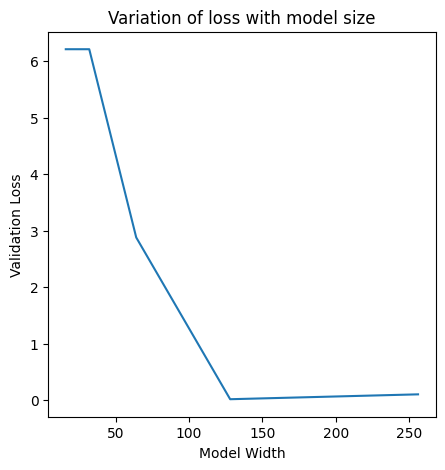

In [24]:
def main():
  vocab_size = 500
  max_len = 40
  d_models = [16, 32, 64, 128, 256]
  diff = 64
  heads = 4
  layers = 2
  batch_size = 128
  epochs = 500
  evals = 1000

  losses_all = []

  for d_model in d_models:
    model = RandomNumberTransformer(
        d_model = d_model,
        heads = heads,
        diff = diff,
        num_layers = layers,
        vocab_size = vocab_size,
        max_len = max_len
    )
    rng = jax.random.PRNGKey(42)
    rng, init_rng = jax.random.split(rng)
    state = create_train_state(
        init_rng,
        model,
        input_shape = (batch_size, max_len)
    )

    losses = []
    for i in range(epochs):
      batch = generate_random_number_sequence(batch_size, max_len, vocab_size)
      state, loss = train_step(state, batch)
      losses.append(loss)

      if i % 10 == 0:
        print(f"Epoch: {i} | Loss: {loss}")

    test_input = generate_random_number_sequence(1, max_len, vocab_size)
    generated_logits = model.apply({"params": state.params}, test_input, training = False)
    generated_logits = jax.nn.log_softmax(generated_logits, axis = -1)
    generated_sequence = jnp.argmax(generated_logits, axis = -1).reshape(max_len,)
    print(f"Generated Sequence: {generated_sequence}")
    losses_all.append(losses[-1])

  plt.figure(figsize = (5, 5))
  plt.plot(d_models, losses_all)
  plt.title("Variation of loss with model size")
  plt.xlabel("Model Width")
  plt.ylabel("Validation Loss")
  plt.show()


if __name__ == "__main__":
  main()